In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from google.colab import files
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [0]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)

cf = submit1_df #retaining the dataframe in cf instead incase I want to look at the original without edits
cf.min_to_subway = cf.min_to_subway.fillna(cf.min_to_subway.mean(), axis=0) #Replacing empty values with the mean of the entire column
cf.year_built = cf.year_built.fillna(cf.year_built.median(), axis=0) #Replacing empty values with the median of the entire column




In [0]:
train_df.sample(5).transpose()

rental_id,7229284,7215520,7311652,7388557,7322155
addr_unit,#5AA,#A,#214,#2,#2F
building_id,386185,91474,133315,700879,123712
bedrooms,1,1,0,1,2
bathrooms,1,1,1,1,1
size_sqft,700,900,900,550,900
created_at,2018-06-01 16:03:21,2018-05-29 13:25:07,2018-06-27 12:11:25,2018-07-20 17:35:03,2018-06-30 14:14:50
addr_street,24 COOK STREET,1721 LEXINGTON AVENUE,50 BRIDGE STREET,8629 16 AVENUE,676 RIVERSIDE DRIVE
addr_city,Brooklyn,New York,Brooklyn,Brooklyn,New York
addr_zip,11206,10029,11201,11214,10031
addr_lat,40.7021,40.7931,40.7033,40.6093,40.8267


#### Build training data

In [0]:

feature_cols = [
    'bedrooms', 'year_built', 'bathrooms', 'min_to_subway',
]
train_features = train_df[feature_cols] 

# impute missing values with medians
train_features = train_features.fillna(train_features.median(), axis=0)

# construct target vector
train_target = train_df['rent']

#### Fit model

In [293]:
lreg = LinearRegression()
lreg.fit(train_features, train_target)

rf = RandomForestRegressor()
rf.fit(train_features, train_target)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

#### Predict and Measure Using Test 1

In [294]:
test_features = test_df[feature_cols] 

# impute missing values with medians
test_features = test_features.fillna(train_features.median(), axis=0)

# construct predictions 
test_df['predicted'] = lreg.predict(test_features)

mean_squared_error(test_df['rent'], test_df['predicted'])

5144072.597655623

#### Combine Data, Predict Values for Test 2

In [295]:
master_df = train_df.append(test_df, sort=False)

master_features = master_df[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
master_target = master_df['rent']

rf.fit(master_features, master_target)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [175]:
train_df.corr() #Looking at which features correlate the most with the rent from the training data

,building_id,bedrooms,bathrooms,size_sqft,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,year_built,min_to_subway,has_doorman,has_elevator,has_fireplace,has_dishwasher,is_furnished,has_gym,allows_pets,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,floornumber
building_id,1.000000,-0.001813,-0.016501,-0.006433,0.064199,-0.008653,0.105315,0.117460,0.090194,-0.116488,0.026593,-0.006980,-0.042830,0.061696,-0.031611,0.023323,-0.012521,0.004550,0.040899,-0.030651,0.099141,-0.012773,-0.060398,0.038340,0.064100,0.011357,-0.035145,0.052429,-0.003418
bedrooms,-0.001813,1.000000,0.464287,0.525537,0.187639,-0.114986,0.093089,0.142331,0.151078,-0.228858,-0.056614,0.014171,-0.233059,-0.278231,0.049998,0.046002,-0.046021,-0.206094,0.023819,0.117120,-0.116837,-0.085111,-0.202524,-0.091116,0.048234,-0.083456,0.353337,-0.004335,-0.158895
bathrooms,-0.016501,0.464287,1.000000,0.565788,-0.088524,0.028441,-0.062992,-0.100642,-0.106358,0.091489,-0.004480,0.017966,0.108987,0.095867,0.124532,0.161132,0.050068,0.113062,0.087348,0.298722,0.051650,0.102592,0.105276,0.089527,0.104741,0.111949,0.611987,-0.003053,0.116938
size_sqft,-0.006433,0.525537,0.565788,1.000000,0.000576,-0.037717,-0.035054,-0.013148,-0.011608,0.020547,-0.021524,0.007718,0.047766,0.029836,0.155044,0.111761,0.041965,0.022605,0.032325,0.263907,0.005959,0.026781,0.040962,0.051020,0.137652,0.068867,0.649984,-0.074162,0.054328
addr_zip,0.064199,0.187639,-0.088524,0.000576,1.000000,-0.577385,0.462277,0.950995,0.952018,-0.447352,-0.004916,0.023660,-0.410034,-0.362939,-0.072233,-0.166108,-0.135857,-0.287916,-0.115378,-0.113234,-0.116047,-0.107670,-0.354300,-0.193333,-0.006699,-0.162588,-0.325241,-0.066025,-0.376063
addr_lat,-0.008653,-0.114986,0.028441,-0.037717,-0.577385,1.000000,0.219029,-0.429858,-0.424711,0.195647,-0.002415,-0.026215,0.191486,0.167685,0.019505,0.078029,0.054610,0.115376,0.015503,0.013967,0.057687,-0.000782,0.146865,0.104243,0.000178,0.066387,0.109536,0.002401,0.170598
addr_lon,0.105315,0.093089,-0.062992,-0.035054,0.462277,0.219029,1.000000,0.554511,0.563806,-0.281790,-0.003623,-0.012528,-0.259673,-0.182011,-0.070451,-0.138343,-0.085478,-0.224737,-0.153365,-0.165555,-0.055615,-0.168426,-0.270704,-0.100606,-0.038981,-0.140828,-0.262711,-0.041091,-0.239193
bin,0.117460,0.142331,-0.100642,-0.013148,0.950995,-0.429858,0.554511,1.000000,0.994155,-0.426813,0.010451,0.021091,-0.380284,-0.326176,-0.084767,-0.173532,-0.131706,-0.263453,-0.144695,-0.119801,-0.089042,-0.112548,-0.323696,-0.182156,-0.007928,-0.144938,-0.332165,-0.111486,-0.350957
bbl,0.090194,0.151078,-0.106358,-0.011608,0.952018,-0.424711,0.563806,0.994155,1.000000,-0.442496,0.005694,0.015880,-0.403373,-0.351657,-0.081656,-0.185248,-0.132950,-0.292240,-0.160086,-0.137143,-0.109457,-0.135245,-0.346828,-0.193851,-0.021434,-0.169315,-0.339157,-0.126716,-0.367065
floor_count,-0.116488,-0.228858,0.091489,0.020547,-0.447352,0.195647,-0.281790,-0.426813,-0.442496,1.000000,0.151318,-0.011722,0.664202,0.560443,-0.024808,0.229530,0.112042,0.633673,0.205669,0.177199,0.380581,0.361168,0.655252,0.498138,0.084536,0.395460,0.253517,0.185316,0.769707


#### Create Submission File for `test2`

In [296]:
submit1_features = cf[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
cf['predictions'] = lreg.predict(submit1_features) 
cf['predictions'].to_csv('sample_submission1.csv', header=True)

cf['fake_rent'] = np.ones(cf['predictions'].shape) * master_target.median()
mean_squared_error(cf['predictions'], cf['fake_rent'])

3155241.3377373447

In [0]:
files.download("sample_submission1.csv")

In [254]:

test = cf.sort_values(['predictions'], ascending=[0])
print(test)

          addr_unit  building_id  bedrooms  ...  line   predictions fake_rent
rental_id                                   ...                              
7500253         #7D        32875         5  ...     D  15516.024836    2900.0
7446163       #PH2C          313         4  ...    2C  15276.501589    2900.0
7449094          #3       224221         6  ...   NaN  12789.071577    2900.0
7517113     TRIPLEX        59899         6  ...   NaN  12787.837419    2900.0
7446625         NaN        56641         5  ...   NaN  12551.060237    2900.0
...             ...          ...       ...  ...   ...           ...       ...
7489150        #2AA       242506         0  ...    AA   2500.656408    2900.0
7483219        #20C         1492         0  ...     C   2500.349193    2900.0
7450882        #1RW        15763         0  ...    RW   2498.538386    2900.0
7485220         #A1       134308         2  ...     A   1729.374457    2900.0
7491649         #F3      1266805         2  ...     F     35.286

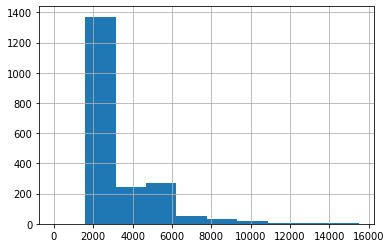

In [258]:
test['predictions'].hist() #Confirming largest predicted rent is 15516 visually. As expected we see that there are more apartments ranging from 2k-3k than any other price range.

#### Create Submission File for `test3`

In [239]:
submit2_features = submit2_df[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
submit2_df['predictions'] = lreg.predict(submit2_features)
submit2_df['predictions'].to_csv('sample_submission2.csv', header=True)

submit2_df['fake_rent'] = np.ones(submit2_df['predictions'].shape) * master_target.median()
mean_squared_error(submit2_df['predictions'], submit2_df['fake_rent'])

2608675.2630168954